<font size ="4">**Importing all the libraries**</font>

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re
import nltk
import os


from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import neighbors , metrics , svm

In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/u194149/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/u194149/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/u194149/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<font size ="4">**Downloading the dataset and extracting it to the appropriate data directory.**</font>

In [5]:
data_directory = 'data/'
if not os.path.exists(data_directory):
    !mkdir data/
    !wget https://onlineacademiccommunity.uvic.ca/isot/wp-content/uploads/sites/7295/2023/03/News-_dataset.zip --directory-prefix=data/
    !unzip data/News-_dataset.zip -d data/

<font size="4">**Read the data csv file**</font>

In [6]:
fake_data = pd.read_csv('data/Fake.csv')
# fake_data.head()

In [7]:
true_data = pd.read_csv('data/True.csv')
# true_data.head()

Assigning Classes to the Dataset

In [8]:
true_data["label"] = 1
fake_data["label"] = 0

Merging Both the Dataset

In [9]:
data = pd.concat([true_data, fake_data], axis=0)

Visualization of the text data based on subject column

[Text(0, 0, 'politicsNews'),
 Text(1, 0, 'worldnews'),
 Text(2, 0, 'News'),
 Text(3, 0, 'politics'),
 Text(4, 0, 'Government News'),
 Text(5, 0, 'left-news'),
 Text(6, 0, 'US_News'),
 Text(7, 0, 'Middle-east')]

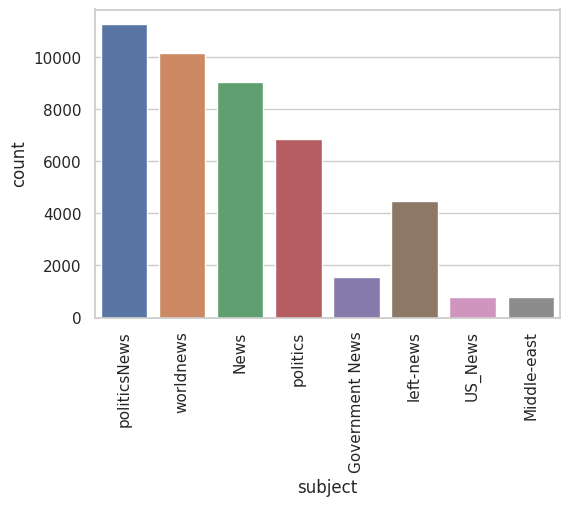

In [10]:
plt.figure(figsize = (6,4))
sns.set(style = "whitegrid",font_scale = 1.0)
chart = sns.countplot(x = "subject", data = data)
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)

<font size="4">**Data preprocessing**</font>

In [11]:
data['text'] = data['title'] +' '+data['text']
# Either you could data.drop["column names"] or del data["column names"]
del data['title']
del data['subject']
del data['date']

In [12]:
data.head()

,text,label
0,"As U.S. budget fight looms, Republicans flip t...",1
1,U.S. military to accept transgender recruits o...,1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,1
3,FBI Russia probe helped by Australian diplomat...,1
4,Trump wants Postal Service to charge 'much mor...,1


As the title, author column will not going to be helpful in identification of the news. So, we can drop these column.

In [13]:
data.shape

(44898, 2)

Check if there is any null value (If so, then we will drop those rows)

In [14]:
data.isnull().sum() # get the count of missing/NULL values for each column. if present remove missing values

text     0
label    0
dtype: int64

 Now we have to shuffle the dataset to prevent the model to get bias

In [15]:
#Shuffling the data by sampling it randomly, then resetting the index and dropping the previous index column
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,text,label
0,Medicaid cuts coming in Trump budget: Washingt...,1
1,Fox Host Gives Trump The Most PATHETICALLY De...,0
2,DELETED REPORT EXPOSES Major Muslim Government...,0
3,Lynch says meeting with Bill Clinton 'casts a ...,1
4,House panel to weigh expanding Puerto Rico ove...,1


Now Let’s explore the unique values in the each category using below code.

<Axes: xlabel='label', ylabel='count'>

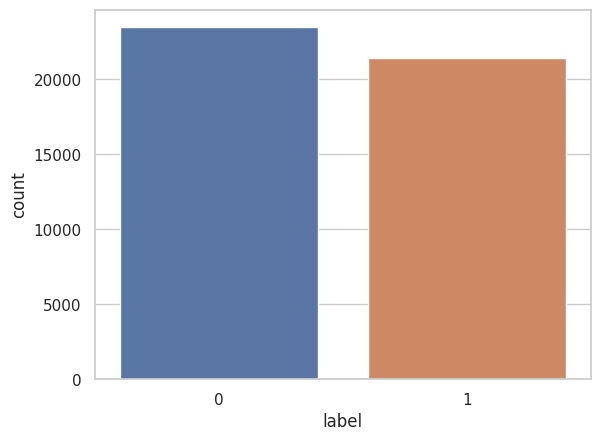

In [16]:
sns.countplot(data=data,
              x='label',
              order=data['label'].value_counts().index)

<font size="4">**Data Cleaning**</font>

Once we have all the required modules, we can create a function name preprocess text. This function will preprocess all the data given as input.

In [17]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string

def preprocess_text(text):
    
    # lower-case the text
    text = text.lower()
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    text = word_tokenize(text) # word has been splited

    for i in text:
        lemmatizer.lemmatize(i)
    
    #removing the stop words and punctuation
    stopword = set(stopwords.words('english'))
    stopword.update(list(string.punctuation))
    stopword.update(['"'])
    
    word = str()
    for i in text:
        if i not in stopword:
            word += i
            word += " "
    


    
    return word

data['text'] = data['text'].apply(preprocess_text)

<font size="4">**Converting text into Vectors**</font>

In [18]:
#TODO: explore different vectorization available with sklearn.feature_extraction.text
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np

x , y = data['text'] , data['label']

vector = CountVectorizer()
x = vector.fit_transform(x)


<font size="4">**Spliting the data for the model**</font>

In [19]:
x_train , x_test , y_train , y_test = train_test_split(x , y, test_size = 0.4)

<font size="4">**Model training, Evaluation, and Prediction**</font>

<font size = 4>**Logistic Regression Model**<font>

In [20]:
#Creating the obj for the model:class
LR = LogisticRegression()

#training the model using the train dataset
LR.fit(x_train , y_train)

/opt/intel/inteloneapi/intelpython/latest/lib/python3.9/site-packages/daal4py/sklearn/linear_model/logistic_path.py:574: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [21]:
#Finding the Accuracy score of the model for the particular data set
scoreLogisticRegression = accuracy_score(LR.predict(x_test) , y_test)
print("The Accuracy Score of the LogisticRegression %.2f " % scoreLogisticRegression,end = "% out of 1.0")

The Accuracy Score of the LogisticRegression 1.00 % out of 1.0

In [22]:
#Classfication Report
print(classification_report(y_test , LR.predict(x_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9350
           1       1.00      1.00      1.00      8610

    accuracy                           1.00     17960
   macro avg       1.00      1.00      1.00     17960
weighted avg       1.00      1.00      1.00     17960



In [23]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
cnLR = confusion_matrix(y_true = y_test , y_pred = LR.predict(x_test))
cnLR

array([[9314,   36],
       [  22, 8588]])

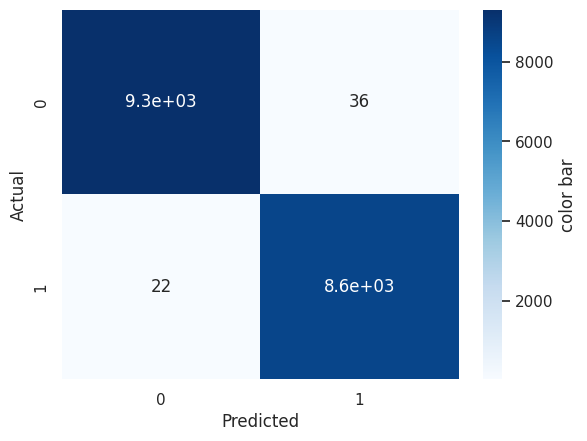

In [24]:
sns.heatmap(cnLR , cmap = 'Blues' , annot = True , cbar_kws = {"label":"color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<font size = 4>**Random Forest Algorithm**<font>

In [25]:
#Creating the obj for the model:class
RF = RandomForestClassifier(criterion = 'gini' , max_depth = 8 , min_samples_split = 10 , random_state = 5)

#training the model using the train dataset
RF.fit(x_train , y_train)

RandomForestClassifier(max_depth=8, min_samples_split=10, random_state=5)

In [26]:
scoreRandomForest = accuracy_score(RF.predict(x_test) , y_test)
print("The Accuracy Score of the Random Forest %.2f " % scoreRandomForest,end = "% out of 1.0")

The Accuracy Score of the Random Forest 0.98 % out of 1.0

In [27]:
print(classification_report(y_test , RF.predict(x_test)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      9350
           1       0.99      0.96      0.97      8610

    accuracy                           0.98     17960
   macro avg       0.98      0.98      0.98     17960
weighted avg       0.98      0.98      0.98     17960



In [28]:
cnRF = confusion_matrix(y_true = y_test , y_pred = RF.predict(x_test))
cnRF

array([[9224,  126],
       [ 303, 8307]])

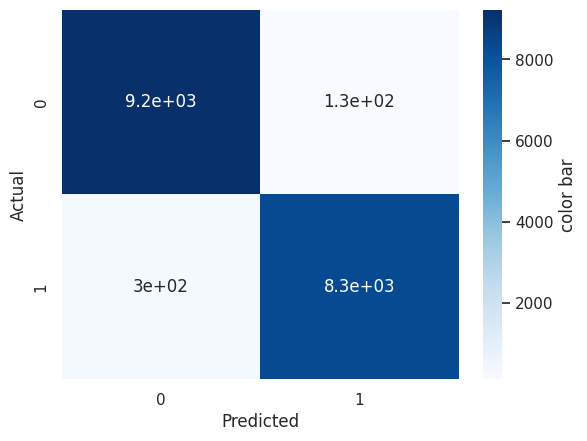

In [29]:
#heat map for he confusion matrix
sns.heatmap(cnRF , cmap = 'Blues' , annot = True , cbar_kws = {"label":"color bar"})
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

<font size = 4>**Navie Bayes Algorithm**<font>

In [30]:
#Creating the obj for the model:class
NF = MultinomialNB()

#training the model using train dataset
NF.fit(x_train , y_train)

MultinomialNB()

In [31]:
scoreNavieBayes = accuracy_score(NF.predict(x_test) , y_test)
print("The Accuracy Score of the Navie Bayes %.2f " % scoreNavieBayes,end = "% out of 1.0")

The Accuracy Score of the Navie Bayes 0.96 % out of 1.0

In [32]:
print(classification_report(NF.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96      9374
           1       0.95      0.96      0.96      8586

    accuracy                           0.96     17960
   macro avg       0.96      0.96      0.96     17960
weighted avg       0.96      0.96      0.96     17960



In [33]:
cnNF = confusion_matrix(y_true = y_test , y_pred = NF.predict(x_test))
cnNF

array([[8981,  369],
       [ 393, 8217]])

<font size = 4>**Support Vector Machine**<font>

<font size = 4>**SVM : Support Vector Machine**<font>
<font size = 3>
1. About SVM
   SVM was a **supervised classfication** algorithm The goal of the SVM algorithm is to create the best line or decision boundary that can segregate n-dimensional space into classes so that we can easily put the new data point in the correct category in the future.
   SVM chooses the extreme points/vectors that help in creating the hyperplane. These extreme cases are called as support vectors.

2. **Types of SVM**
   1. **Linear Support Vector Machine**
      It was 2-dimensional space and the data will be segregate by using linear line as marign
      
      
   2. **Non-Linear Support Vector Machine**
      It was 3-dimensional space and the data for 3d or more than 3-dimensional space will be using a 3d plane to segregate the data.
      By using linear line could not able to segregate the data as marign but its also a 2d space then its also known as non-linear svm example parabola.
      
      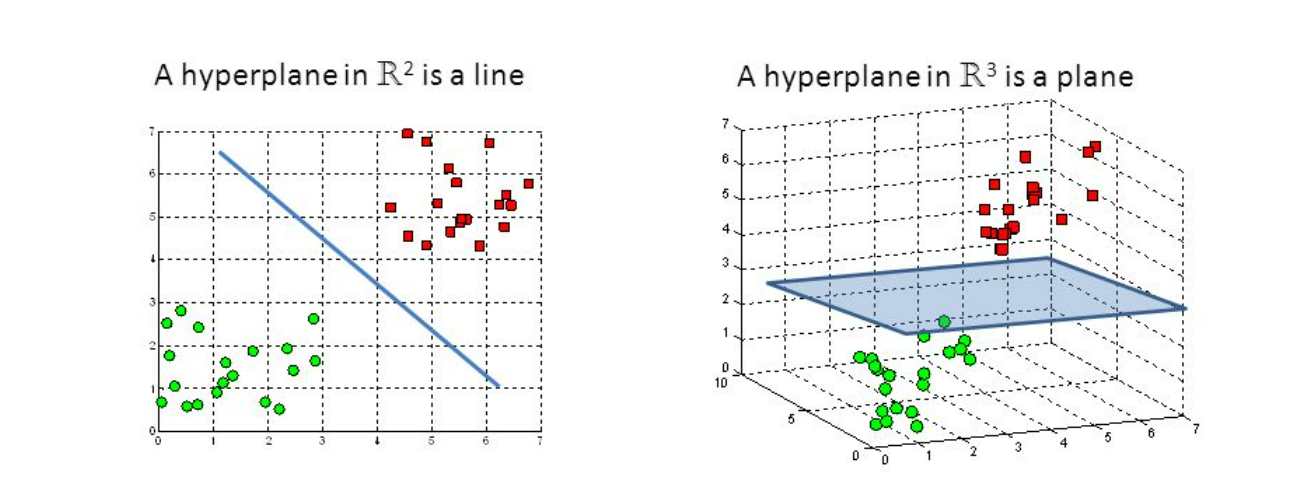
<font>

In [34]:
SVM = svm.SVC(kernel = 'linear' , random_state = 1)

In [35]:
SVM.fit(x_train , y_train)

SVC(kernel='linear', random_state=1)

In [36]:
scoreSupportVectorMachine = accuracy_score(SVM.predict(x_test) , y_test)
print("The Accuracy Score of the Support Vector Machine %.2f " % scoreSupportVectorMachine,end = "% out of 1.0")

The Accuracy Score of the Support Vector Machine 1.00 % out of 1.0

In [37]:
print(classification_report(SVM.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9344
           1       1.00      1.00      1.00      8616

    accuracy                           1.00     17960
   macro avg       1.00      1.00      1.00     17960
weighted avg       1.00      1.00      1.00     17960



In [38]:
cnSVM = confusion_matrix(y_true = y_test , y_pred = SVM.predict(x_test))
cnSVM

array([[9318,   32],
       [  26, 8584]])

<font size = 4>**Gradient Boosting**<font>

<font size = 3>
 About Boosting:The principle behind boosting algorithms is first we built a model on the training dataset, then a second model is built to rectify the errors present in the first model.
<font>

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
GB = GradientBoostingClassifier(n_estimators = 350 , max_features = 5 , learning_rate = 1.2 , random_state = 5)
GB.fit(x_train , y_train)

GradientBoostingClassifier(learning_rate=1.2, max_features=5, n_estimators=350,
                           random_state=5)

In [40]:
scoreGradientBoost = accuracy_score(GB.predict(x_test) , y_test)
print("The Accuracy Score of the Gradient Boosting %.2f " % scoreGradientBoost,end = "% out of 1.0")

The Accuracy Score of the Gradient Boosting 0.83 % out of 1.0

In [41]:
print(classification_report(GB.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      9658
           1       0.80      0.83      0.82      8302

    accuracy                           0.83     17960
   macro avg       0.83      0.83      0.83     17960
weighted avg       0.83      0.83      0.83     17960



In [42]:
cnGB = confusion_matrix(y_true = y_test , y_pred = GB.predict(x_test))
cnGB

array([[7965, 1385],
       [1693, 6917]])

<font size = 4>**Neural Network**<font>

In [43]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-07-03 06:28:01.567350: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 06:28:04.681483: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-07-03 06:28:04.713308: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-03 06:28:25.495789: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-07-03 06:29:01.696076: E itex/core/kernels/xpu_kernel.cc:38] XPU-GPU kernel not supported.
If you need help, create an issue at https://github.com/intel/intel-extension-for-tensorflow/issues


In [44]:
text = np.array(data['text'])

In [45]:
label = np.array(data['label'])

In [46]:
token = Tokenizer()
token.fit_on_texts(text)
word_index = token.word_index
vocab_size = len(word_index) + 1

In [47]:
sequence = token.texts_to_sequences(text)

In [48]:
max_length = max([len(seq) for seq in sequence])

In [49]:
padded = pad_sequences(sequence , maxlen = max_length)

In [50]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(vocab_size , 16 , input_length = max_length , name = "Embedding"),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(16 , activation = 'relu'),
    tf.keras.layers.Dense(1 , activation = 'sigmoid')
])

In [51]:
model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 5182, 16)          2018816   
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 2,019,105
Trainable params: 2,019,105
Non-trainable params: 0
_________________________________________________________________


In [64]:
paddedX_train ,paddedX_test ,paddedY_train ,paddedY_test = train_test_split(padded , label , test_size = 0.4)

In [65]:
model.fit(paddedX_train , paddedY_train , epochs = 2)

Epoch 1/2
  4/842 [..............................] - ETA: 36s - loss: 8.4186e-04 - accuracy: 1.0000

2023-07-03 06:53:18.099844: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-03 06:53:18.108294: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-03 06:53:18.119967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


842/842 [==============================] - 29s 34ms/step - loss: 2.0992e-04 - accuracy: 1.0000
Epoch 2/2
842/842 [==============================] - 29s 34ms/step - loss: 5.7209e-04 - accuracy: 0.9998


In [70]:
scoreNeuralNetwork = model.evaluate(paddedX_test , paddedY_test , verbose = 0)
print("The Accuracy Score of the Neural Network of Sequential Model %.2f " % scoreNeuralNetwork[1],end = "% out of 1.0")

2023-07-03 07:54:34.451643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-03 07:54:34.459200: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.
2023-07-03 07:54:34.471251: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type CPU is enabled.


The Accuracy Score of the Neural Network of Sequential Model 1.00 % out of 1.0

<font size = 4>**Decision Tree Classifier**<font>

In [54]:
from sklearn.tree import DecisionTreeClassifier

In [55]:
DTC = DecisionTreeClassifier(max_leaf_nodes = 11 , random_state = 0)

In [56]:
DTC.fit(x_train , y_train)

DecisionTreeClassifier(max_leaf_nodes=11, random_state=0)

In [57]:
scoreDecisionTreeClassifier = accuracy_score(DTC.predict(x_test) , y_test)


In [58]:
print(classification_report(DTC.predict(x_test) , y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9334
           1       1.00      1.00      1.00      8626

    accuracy                           1.00     17960
   macro avg       1.00      1.00      1.00     17960
weighted avg       1.00      1.00      1.00     17960



In [59]:
cnDTC = confusion_matrix(y_true = y_test , y_pred = DTC.predict(x_test))
cnGB

array([[7965, 1385],
       [1693, 6917]])